In [1]:
import pandas as pd
from pathlib import Path
import subprocess
from tqdm import tqdm
from datetime import datetime
import json
from statistics import mean
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
# === PURPOSE ===



In [20]:
scraped_data = pd.read_json('/Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/speeches_boe.json')

ValueError: If using all scalar values, you must pass an index

In [17]:
scraped_data.conclusion_text.isnull().sum()

0

In [24]:
import json
from pathlib import Path

# --- Configuration ---
JSON_PATH = Path("/Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/speeches_boe.json")
PREFIX_TO_CLEAN = "Home\n"

def clean_json_text_and_display():
    """Loads the JSON file, strips the prefix from all values, and prints a sample."""
    try:
        with JSON_PATH.open("r", encoding="utf-8") as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"❌ Error: JSON file not found at {JSON_PATH}. Please run the scraper first.")
        return
    except json.JSONDecodeError:
        print(f"❌ Error: Could not decode JSON from {JSON_PATH}. File might be corrupted.")
        return

    cleaned_data = {}
    
    # Process each entry in the dictionary
    for date, raw_text in data.items():
        if raw_text and raw_text.startswith(PREFIX_TO_CLEAN):
            cleaned_text = raw_text[len(PREFIX_TO_CLEAN):]
        else:
            cleaned_text = raw_text
        
        cleaned_data[date] = cleaned_text

    print(f"✅ Successfully loaded and cleaned text from {len(cleaned_data)} speeches.")
    
    # Display a sample entry for verification
    if cleaned_data:
        sample_date = next(iter(cleaned_data))
        print("\n--- Sample Cleaned JSON Entry ---")
        print(f'"{sample_date}": "{cleaned_data[sample_date][:150]}..."')
        print("---------------------------------")
        
    # If you needed to save this cleaned data back to a *new* file, 
    # you would use the following lines (e.g., save as cleaned_speeches.json)
    # ----------------------------------------------------------------------
    new_path = Path("/Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/cleaned_speeches.json")
    with new_path.open("w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=4)
    print(f"💾 Saved cleaned JSON to {new_path}")



clean_json_text_and_display()

✅ Successfully loaded and cleaned text from 134 speeches.

--- Sample Cleaned JSON Entry ---
"2025-10-08": "Uncertainty, structural change and monetary policy strategy - speech by Huw Pill
Speech
Thanks to Profs. Binner and Jayakody for their invitation to p..."
---------------------------------
💾 Saved cleaned JSON to /Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/cleaned_speeches.json


In [29]:
import pandas as pd
import json
from pathlib import Path
import re

# --- Configuration ---
CSV_INPUT_PATH = Path("/Users/murat/Desktop/Capstone/FinGlobe_Agent/boe_publications.csv")
JSON_OUTPUT_PATH = Path("/Users/murat/Desktop/Capstone/FinGlobe_Agent/publications_boe.json")

# Artifact to clean from the summary text
# Note: The artifact is likely "Home\n" or "Home \n" from the scraper output
# We use lstrip to handle variations.
CHARACTERS_TO_CLEAN = "Home/\n " # Added space to be robust

# The actual column names in your CSV
DATE_COLUMN_NAME = 'published'
SUMMARY_COLUMN_NAME = 'summary'

def generate_json_from_csv():
    """Loads CSV, extracts date/summary, cleans text, and saves to JSON."""
    print(f"1. Loading CSV from: {CSV_INPUT_PATH}")
    
    # --- Load Data ---
    try:
        df = pd.read_csv(CSV_INPUT_PATH)
    except FileNotFoundError:
        print(f"❌ Error: CSV file not found at {CSV_INPUT_PATH}. Please check the path.")
        return
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        return

    # Check for required columns
    required_cols = [DATE_COLUMN_NAME, SUMMARY_COLUMN_NAME]
    if not all(col in df.columns for col in required_cols):
        print(f"❌ Error: CSV must contain '{DATE_COLUMN_NAME}' and '{SUMMARY_COLUMN_NAME}' columns.")
        print(f"Found columns: {df.columns.tolist()}")
        return

    # --- Process and Format Data ---
    json_output = {}
    
    print(f"2. Processing {len(df)} rows and cleaning text...")
    
    # Iterate through DataFrame rows
    for _, row in df.iterrows():
        # Use the correct 'published' column for the date
        date_str = str(row[DATE_COLUMN_NAME]) 
        summary_text = str(row[SUMMARY_COLUMN_NAME])

        # Ensure date is valid and format is correct (YYYY-MM-DD)
        if not re.match(r"\d{4}-\d{2}-\d{2}", date_str):
            # Attempt to convert if the format is slightly off, then skip if still invalid
            try:
                date_str = pd.to_datetime(date_str).strftime('%Y-%m-%d')
            except ValueError:
                continue

        # Clean the summary text
        if summary_text:
            cleaned_text = summary_text.lstrip(CHARACTERS_TO_CLEAN)
        else:
            cleaned_text = ""

        # Populate the JSON dictionary
        if cleaned_text:
             json_output[date_str] = cleaned_text

    # --- Save JSON ---
    print(f"3. Saving processed data to JSON: {JSON_OUTPUT_PATH}")
    
    try:
        JSON_OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
        with JSON_OUTPUT_PATH.open("w", encoding="utf-8") as f:
            json.dump(json_output, f, indent=4)
        
        print(f"✅ Successfully generated JSON file with {len(json_output)} entries.")
        
    except Exception as e:
        print(f"❌ Error saving JSON file: {e}")
        
if __name__ == "__main__":
    generate_json_from_csv()

1. Loading CSV from: /Users/murat/Desktop/Capstone/FinGlobe_Agent/boe_publications.csv
2. Processing 3471 rows and cleaning text...
3. Saving processed data to JSON: /Users/murat/Desktop/Capstone/FinGlobe_Agent/publications_boe.json
✅ Successfully generated JSON file with 95 entries.


In [30]:
import pandas as pd
import json
from pathlib import Path
import re

# --- Configuration ---
JSON_PATH = Path("/Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/publications_boe.json")

def process_json_dates(json_path):
    """
    Reads the JSON file, reformats ISO 8601 date keys to YYYY-MM-DD,
    and handles date duplication by concatenating text values.
    """
    print(f"1. Loading JSON from: {json_path}")
    
    try:
        with json_path.open("r", encoding="utf-8") as f:
            raw_data = json.load(f)
    except FileNotFoundError:
        print(f"❌ Error: JSON file not found at {json_path}.")
        return
    except json.JSONDecodeError:
        print(f"❌ Error: Could not decode JSON from {json_path}. File might be corrupted.")
        return

    reformatted_data = {}
    
    print(f"2. Processing {len(raw_data)} entries and reformatting dates...")
    
    for iso_date_str, text_value in raw_data.items():
        if not iso_date_str:
            continue
            
        try:
            # 1. Convert the ISO 8601 string to a pandas Timestamp object (handles timezone)
            # Use pandas.to_datetime for robust ISO 8601 parsing
            dt_obj = pd.to_datetime(iso_date_str)
            
            # 2. Convert the object to the desired format (YYYY-MM-DD string)
            new_date_str = dt_obj.strftime('%Y-%m-%d')
            
            # 3. Handle duplicates (multiple entries on the same day after time truncation)
            # Concatenate text if the date already exists and the new text is not empty.
            if new_date_str in reformatted_data:
                current_text = reformatted_data[new_date_str]
                if text_value and text_value.strip():
                    # Concatenate with a space separator
                    reformatted_data[new_date_str] = current_text + " " + text_value
            else:
                reformatted_data[new_date_str] = text_value
                
        except ValueError:
            # Skip entries with unparseable date strings
            print(f"⚠️ Skipping entry due to invalid date string: {iso_date_str}")
            continue

    # --- Overwrite JSON File ---
    print(f"3. Overwriting JSON file with {len(reformatted_data)} entries...")
    
    try:
        with json_path.open("w", encoding="utf-8") as f:
            json.dump(reformatted_data, f, indent=4)
        
        print(f"✅ Successfully reformatted and saved JSON to {json_path.resolve()}")
        
    except Exception as e:
        print(f"❌ Error saving JSON file: {e}")
        
if __name__ == "__main__":
    process_json_dates(JSON_PATH)

1. Loading JSON from: /Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/publications_boe.json
2. Processing 95 entries and reformatting dates...
3. Overwriting JSON file with 91 entries...
✅ Successfully reformatted and saved JSON to /Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/publications_boe.json


1. Loading combined data from: /Users/murat/Desktop/Capstone/FinGlobe_Agent/data/analysis_results/combined_monthly_scores.csv
2. Plotting 54 monthly observations, starting 2021-01...

💾 Saved plot to /Users/murat/Desktop/Capstone/FinGlobe_Agent/data/analysis_results/combined_hawkishness_plot_filtered.png


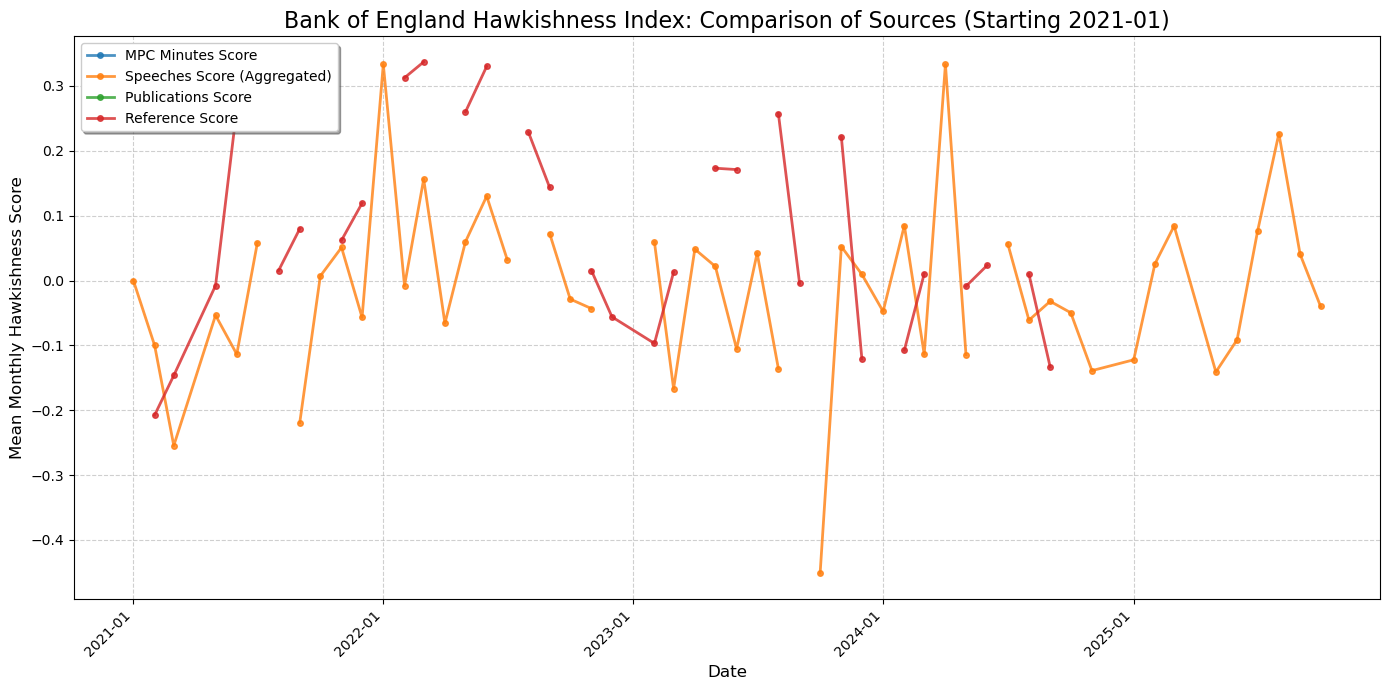

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# --- Configuration ---
INPUT_CSV = Path("/Users/murat/Desktop/Capstone/FinGlobe_Agent/data/analysis_results/combined_monthly_scores.csv")
PLOT_OUTPUT_PATH = Path("/Users/murat/Desktop/Capstone/FinGlobe_Agent/data/analysis_results/combined_hawkishness_plot_filtered.png") # Changed filename to reflect filtering

def plot_combined_scores():
    """Loads the combined monthly scores and plots all four series, starting from the earliest non-NaN score."""
    print(f"1. Loading combined data from: {INPUT_CSV}")
    
    try:
        df = pd.read_csv(INPUT_CSV)
    except FileNotFoundError:
        print(f"❌ Error: Combined scores file not found at {INPUT_CSV}. Please run the scoring script first.")
        return
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        return

    # --- Data Preparation ---
    try:
        df['Date'] = pd.to_datetime(df['month_period'], format='%Y,%m')
    except Exception as e:
        print(f"❌ Error converting 'month_period' to datetime: {e}")
        print("Please ensure the column is in 'YYYY,MM' format.")
        return

    # Define the score columns and the non-reference scored columns
    score_cols = ['scores_minutes', 'scores_speeches', 'scores_publications', 'scores_reference']
    scored_cols = ['scores_minutes', 'scores_speeches', 'scores_publications']

    # --- NEW: Determine the earliest non-NaN start date ---
    # 1. Identify rows where at least one scored column (non-reference) has a value
    df_scored = df.dropna(subset=scored_cols, how='all').copy()

    # 2. Find the minimum date from this filtered set
    if df_scored.empty:
        print("❌ Error: No months found with scores in Minutes, Speeches, or Publications.")
        return
        
    start_date = df_scored['Date'].min()
    
    # 3. Filter the original DataFrame to start from this date
    df_filtered = df[df['Date'] >= start_date].copy()
    
    # Drop rows where all score columns are NaN in the final filtered set
    df_filtered = df_filtered.dropna(subset=score_cols, how='all')
    df_filtered = df_filtered.sort_values('Date')
    
    print(f"2. Plotting {len(df_filtered)} monthly observations, starting {start_date.strftime('%Y-%m')}...")

    # --- Plotting ---
    plt.figure(figsize=(14, 7))
    
    # Define labels for the plot legend
    labels = {
        'scores_minutes': 'MPC Minutes Score',
        'scores_speeches': 'Speeches Score (Aggregated)',
        'scores_publications': 'Publications Score',
        'scores_reference': 'Reference Score'
    }

    # Plot each series
    for col in score_cols:
        # Use filtered DataFrame for plotting
        plt.plot(df_filtered['Date'], df_filtered[col], label=labels[col], marker='o', linewidth=2, markersize=4, alpha=0.8)

    # --- Customizations ---
    plt.title(f'Bank of England Hawkishness Index: Comparison of Sources (Starting {start_date.strftime("%Y-%m")})', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Mean Monthly Hawkishness Score', fontsize=12)
    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Format x-axis ticks to show year and month
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # --- Save and Display ---
    PLOT_OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(PLOT_OUTPUT_PATH, dpi=300)
    print(f"\n💾 Saved plot to {PLOT_OUTPUT_PATH.resolve()}")
    plt.show()

if __name__ == "__main__":
    plot_combined_scores()

In [35]:
reference=pd.read_csv('/Users/murat/Desktop/Capstone/FinGlobe_Agent/data/raw/boe_reference_scores.csv')
reference.head()

Hawkishness Date  Hawkishness
0       2013-08-01    -0.057895
1       2013-06-06    -0.202899
2       2013-07-04    -0.043165
3       2013-11-07    -0.073620
4       2013-01-10    -0.159236